In [29]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keys import api, secret
from pybit.unified_trading import HTTP


session = HTTP(
    api_key=api,
    api_secret=secret)

session = HTTP(api_key=api, api_secret=secret)


In [35]:

def get_klines():
    try:
        resp = session.get_kline(
            category='linear',
            symbol='BTCUSDT',
            interval=1,
            limit=750
        )['result']['list']
        df = pd.DataFrame(resp)
        df.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Turnover']
        df = df.set_index('Time').astype(float).iloc[::-1]
        return df
    except Exception as e:
        print(f"Error fetching klines: {e}")
        return None

In [39]:
df=get_klines()
ema_12 = df['Close'].ewm(span=12, min_periods=12).mean()
ema_26 = df['Close'].ewm(span=26, min_periods=26).mean()
macd_line = ema_12 - ema_26
signal_line = macd_line.ewm(span=9, min_periods=9).mean()
df['MACD'] = macd_line
df['Signal_Line'] = signal_line

# Calculate 200-period Moving Average
df['200_MA'] = df['Close'].rolling(window=200).mean()

In [42]:
# Generate buy/sell signals
df['Buy_Signal'] = (df['MACD'] > df['Signal_Line']) & (df['Close'] > df['200_MA'])&(df['MACD']>5)
df['Sell_Signal'] = (df['MACD'] < df['Signal_Line']) & (df['Close'] < df['200_MA'])&(df['MACD']>-5)


In [45]:
# Implement trading strategy
df['Position'] = np.where((df['MACD'] > df['Signal_Line']) & (df['Close'] > df['200_MA']), 1, 0)
df['Position'] = np.where((df['MACD'] < df['Signal_Line']) & (df['Close'] < df['200_MA']), -1, df['Position'])

# Calculate returns
df['Returns'] = df['Close'].pct_change() * df['Position'].shift(1)


In [48]:

# Calculate returns
df['Returns'] = df['Close'].pct_change() * df['Position'].shift(1)

# Print cumulative returns
cumulative_returns = (df['Returns'] + 1).cumprod() - 1
print("Cumulative Returns:", cumulative_returns.iloc[-1])

Cumulative Returns: 0.000413394264876521


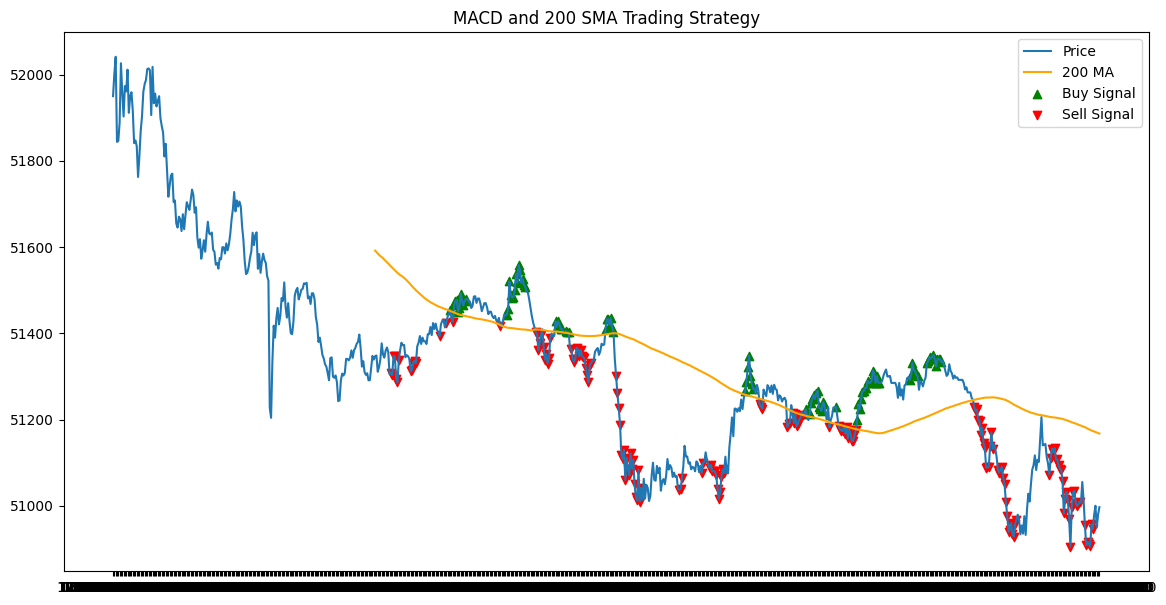

In [50]:
# Plot results
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Price')
plt.plot(df['200_MA'], label='200 MA', color='orange')
plt.scatter(df[df['Position'] == 1].index, df[df['Position'] == 1]['Close'], label='Buy Signal', marker='^', color='g')
plt.scatter(df[df['Position'] == -1].index, df[df['Position'] == -1]['Close'], label='Sell Signal', marker='v', color='r')
plt.legend()
plt.title('MACD and 200 SMA Trading Strategy')
plt.show()

In [37]:
def backtest_strategy(data):
    initial_capital = 10000 # Initial capital in USD
    capital = initial_capital
    position = 0  # 0: No position, 1: Long position, -1: Short position
    buy_price = 0
    sell_price = 0
    trades = []

    for i in range(1, len(data)):
        if data['Buy_Signal'][i] and position == 0:
            position = 1
            buy_price = data['Close'][i]
            capital -= buy_price
        elif data['Sell_Signal'][i] and position == 1:
            position = 0
            sell_price = data['Close'][i]
            capital += sell_price
            trades.append((buy_price, sell_price))

    # Calculate final capital and returns
    final_value = capital + (position * data['Close'].iloc[-1])
    returns = (final_value - initial_capital) / initial_capital * 100

    return final_value, returns, trades


In [38]:
data=get_klines()
data['200_MA'] = data['Close'].rolling(window=200).mean()

# Calculate MACD and Signal line
data['MACD'], data['Signal'] = calculate_macd(data)

# Generate buy/sell signals with stop loss and take profit
data['Buy_Signal'], data['Sell_Signal'] = generate_signals(data)

# Perform backtesting
final_value, returns, trades = backtest_strategy(data)

print("Final Portfolio Value: $", final_value)
print("Total Return: ", returns, "%")

Final Portfolio Value: $ 9905.799999999996
Total Return:  -0.9420000000000437 %


C:\Users\oyomi01\AppData\Local\Temp\ipykernel_28220\2096229056.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if buy_signal[i]:
C:\Users\oyomi01\AppData\Local\Temp\ipykernel_28220\2096229056.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stop_loss_price = data['Close'][i] * (1 - stop_loss_pct)
C:\Users\oyomi01\AppData\Local\Temp\ipykernel_28220\2096229056.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  take_profit_pri

In [ ]:
# Plotting
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price', alpha=0.5)
plt.plot(data['200_MA'], label='200-day MA', alpha=0.5)
plt.scatter(data.index[data['Buy_Signal']], data['Close'][data['Buy_Signal']], marker='^', color='g', label='Buy Signal')
plt.scatter(data.index[data['Sell_Signal']], data['Close'][data['Sell_Signal']], marker='v', color='r', label='Sell Signal')
plt.title('Enhanced Crypto Trading Strategy with MACD, 200-day MA, Stop Loss, and Take Profit')
plt.legend()
plt.show()